# Quantum Tunnelling in Nuclear Fusion

## Quantum Circuit as described in the attached PDF

### Imports

In [12]:
import pennylane as qml
import numpy as np

### Setup 
Defining constants, device initialization and implementing a generalized controlled unitary gate

In [13]:
num_qubits = 3 # For a single particle

# Initialize a device
dev = qml.device("default.qubit", num_qubits * 2 )

# Implement a controlled unitary gate with specified control values and unitary matrix
def controlledUnitary(unitary: np.ndarray, control_wires: list, control_values: list, target_wire: int):
    """    
    Precondition:
    - len(control_wires) == len(control_values)
    """
    
    if len(control_wires) != len(control_values):
        raise IndexError


    for i in range(len(control_wires)):
        if not control_values[i]:
            qml.PauliX(control_wires[i])

    qml.QubitUnitary(unitary, wires=control_wires + [target_wire])

    for i in range(len(control_wires)):
        if not control_values[i]:
            qml.PauliX(control_wires[i])

### Defining the Kinetic Energy Operators
(as outlined in the attached PDF section 3.3)

In [14]:
# Function to be applied while building unitary [f(2k) and f(2k + 1)]
def kinetic_function(k):
    return k**2
 

def kinetic_energy_operator(dt):

    # Apply QFT to both sets of qubits for each particle
    qml.QFT(range(num_qubits, 2*num_qubits))
    qml.QFT(range(num_qubits))

    # Iterate over one set of qubits and apply the controlled unitary gates for each particle separately (since they have the same unitaries)
    for i in range(2 ** (num_qubits - 1)):
        ## Get the control values
        binary_str = format(i, '0' + str(num_qubits - 1) + 'b')

        # Build the unitary to apply
        diagonal = np.ndarray((2 ** num_qubits,), dtype=complex)
        for d in range(len(diagonal)):
            diagonal[d] = 1
        diagonal[-2] = np.exp(- 1j * dt * kinetic_function(2 * i))
        diagonal[-1] = np.exp(- 1j * dt * kinetic_function(2 * i + 1))

        # Apply the controlled unitaries
        controlledUnitary(np.diag(diagonal), list(range(num_qubits - 1)), [int(j) for j in binary_str], num_qubits - 1)
        controlledUnitary(np.diag(diagonal), list(range(num_qubits, 2 * num_qubits - 1)), [int(j) for j in binary_str], 2 * num_qubits - 1)

    # Apply QFT^-1 to both sets of qubits for each particle
    qml.adjoint(qml.QFT)(range(num_qubits))
    qml.adjoint(qml.QFT)(range(num_qubits, 2 * num_qubits))

### Defining the Potential Energy Operators
(as outlined in the attached PDF section 3.4)

In [15]:
# Function to be applied while building unitary [f(x1, 2k) and f(x1, 2k + 1)]
def potential_function(x1, x2):
    # Apply potential if the particles are not in the same section
    if x1 != x2:
        return 50 * num_qubits * 2/abs(x1 - x2)

    # Otherwise create a well for tunnelling (simulating the activation of strong force within this region around each particle)
    return 0

def potential_energy_operator(dt):
    # Iterate over all x1
    for x1 in range(2 ** num_qubits):
        binary_str_x1 = format(x1, "0" + str(num_qubits) + "b")
        # Iterate over all x2
        for x2 in range(2 ** (num_qubits - 1)):
            binary_str_x2 = format(x2, "0" + str(num_qubits - 1) + "b")

            # Building the unitary
            diagonal = np.ndarray((2 ** (2 * num_qubits),), dtype=complex)
            for d in range(len(diagonal)):
                diagonal[d] = 1
            diagonal[-2] = np.exp(- 1j * dt * potential_function(x1, 2 * x2))
            diagonal[-1] = np.exp(- 1j * dt * potential_function(x1, 2 * x2 + 1))

            # Applying the controlled unitary
            controlledUnitary(np.diag(diagonal), list(range(2 * num_qubits - 1)), [int(j) for j in (binary_str_x1 + binary_str_x2)], 2 * num_qubits - 1)

### Defining the Hamiltonian
Combining and applying the kinetic and potential energy operators on the circuit

In [16]:
def hamiltonian(dt):
    
    kinetic_energy_operator(dt)
    
    potential_energy_operator(dt)


@qml.qnode(dev)
def tunnelling_circuit(dt, t):
    # Start each particle at opposite ends of the space
    starting_pos = np.zeros((2 * num_qubits,))
    for i in range(num_qubits, 2 * num_qubits):
        starting_pos[i] = 1
        
    qml.BasisState(starting_pos, wires=range(2 * num_qubits))

    # Apply the hamiltonian repeatedly to simulate the time evolution of the hamiltonian
    for i in range(t):
        hamiltonian(dt)
    return qml.probs()


### Post processing and analysis of output
Analysing the output of the simulation of the time evolution of the quantum system

In [17]:
particle_1_probabilities = []
particle_2_probabilities = []
tunnelling_probabilities = []

for i in range(50):
    results = tunnelling_circuit(1 / 50, i)

    # Probabilities of each particle existing within a given distance interval at time t
    particle_1_probabilities.append([sum([results[2 ** num_qubits * k + j].numpy() for j in range(2 ** num_qubits)]) for k in range(2 ** num_qubits)])
    particle_2_probabilities.append([sum([results[2 ** num_qubits * j + k].numpy() for j in range(2 ** num_qubits)]) for k in range(2 ** num_qubits)])

    # Tunnelling probabilities at each time t
    tunnelling_probabilities.append(sum([sum(results[2 ** num_qubits * k + j].numpy() for j in range(2 ** num_qubits) if j == k) for k in range(2 ** num_qubits)]))


In [18]:
tunnelling_probabilities

[0.0,
 0.06574097101928214,
 0.14966094270739844,
 0.14593374784026536,
 0.0954258513479453,
 0.07049383096152724,
 0.057584937335870896,
 0.04920062639765453,
 0.04362396376805937,
 0.04905300934088897,
 0.05232362751965962,
 0.05510952429298676,
 0.0779936368084499,
 0.09037882055377601,
 0.09095117530836602,
 0.10667029607947379,
 0.11554367179679459,
 0.07727910957206584,
 0.03359003060163048,
 0.04645699715446948,
 0.09327248432907423,
 0.12798531391048004,
 0.12665587690606125,
 0.10836650152072688,
 0.0800539258913711,
 0.06325255605959614,
 0.05856223600238754,
 0.05869373354219557,
 0.05638413352681243,
 0.06888858797003768,
 0.0756307387900431,
 0.06752584032111429,
 0.054085940099099394,
 0.0690012478126253,
 0.09041468761915508,
 0.08170857968892675,
 0.06366642592959279,
 0.07641313639284777,
 0.1035014342449898,
 0.12260083462267875,
 0.13387553462710985,
 0.11755662607609152,
 0.08763302670235741,
 0.05629421973402771,
 0.042201424754921946,
 0.055989583940493706,
 0.071

### Plot the results of the simulation
Plot the position probabilities of each particle as a grayscale plot where white corresponds to certain probability of particle in that distance interval whereas black indicates 0 probabilty of the particle being within that distance interval 

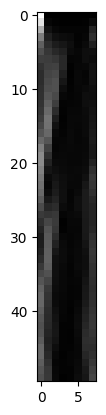

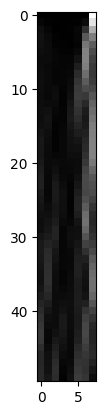

In [19]:
import matplotlib.pyplot as plt

# plot
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

## Plot both particle probabilities
ax1.imshow(particle_1_probabilities, cmap="gray")
ax2.imshow(particle_2_probabilities, cmap="gray")

plt.show()